In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

E0000 00:00:1728248037.566650      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:479
D1006 20:53:57.574982203      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1006 20:53:57.574997436      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1006 20:53:57.575000832      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1006 20:53:57.575003341      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1006 20:53:57.575005770      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defau

In [2]:
# Load the dataset
data = np.load('/kaggle/input/1024age5/AGE_1024_512_Class5.npz')
X_train, y_train = data['X_train'], data['y_train']
X_test, y_test = data['X_test'], data['y_test']

# Reshape the images (from flat to original size)
X_train = X_train.reshape((-1, 512, 1024, 1))  # Grayscale
X_test = X_test.reshape((-1, 512, 1024, 1))

# Convert grayscale to 3 channels by repeating the single channel
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# Normalize pixel values (0-255) to range (0-1)
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (9154, 512, 1024, 3)
y_train shape: (9154, 5)
X_test shape: (2289, 512, 1024, 3)
y_test shape: (2289, 5)


In [3]:
import tensorflow as tf

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# Create a strategy for distributed training
#strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1728248185.962956      13 service.cc:145] XLA service 0x5a49429ee870 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728248185.963032      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1728248185.963037      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1728248185.963040      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1728248185.963043      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1728248185.963047      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1728248185.963050      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1728248185.963052      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1728248185.963055      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
with tpu_strategy.scope():
    # Define the base model with ImageNet weights, without the top layers
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(512, 1024, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Add custom layers on top of the base model
    inputs = Input(shape=(512, 1024, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Custom dense layer
    outputs = Dense(5, activation='softmax')(x)  # Output layer for 2 classes

    # Create the final model
    model = Model(inputs, outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
model.summary()

I0000 00:00:1728248217.742900      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 1024, 3)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 16, 32, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,717 (90.90 MB)

 Trainable params: 262,917 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [5]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # You can increase epochs based on performance
                    batch_size=32,
                    callbacks=[early_stopping])

# Save the model in .keras format
model.save('AP-ResNet50v2_Model_1024Age_Trained.keras')

Epoch 1/100


2024-10-06 21:00:12.471268: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1728248413.806181     808 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(795c54ee756dc80c:0:0), session_name()


  1/287 ━━━━━━━━━━━━━━━━━━━━ 1:23:14 17s/step - accuracy: 0.2500 - loss: 1.1232

I0000 00:00:1728248425.720455     808 tpu_compile_op_common.cc:245] Compilation of 795c54ee756dc80c:0:0 with session name  took 11.914211713s and succeeded
I0000 00:00:1728248425.733989     808 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(795c54ee756dc80c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6986509220301993296", property.function_library_fingerprint = 15871511869711373561, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,512,1024,3,;4,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728248425.734040     808 tpu_compilation_cache_interface.cc:541] After adding entry for key

286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2712 - loss: 1.5656

I0000 00:00:1728248456.998588     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b2b51c5e0494dcb4:0:0), session_name()


287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2715 - loss: 1.5654

I0000 00:00:1728248467.202820     830 tpu_compile_op_common.cc:245] Compilation of b2b51c5e0494dcb4:0:0 with session name  took 10.204194933s and succeeded
I0000 00:00:1728248467.214452     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b2b51c5e0494dcb4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_6986509220301993296", property.function_library_fingerprint = 15871511869711373561, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,512,1024,3,;2,5,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728248467.214482     830 tpu_compilation_cache_interface.cc:541] After adding entry for key

287/287 ━━━━━━━━━━━━━━━━━━━━ 127s 384ms/step - accuracy: 0.2717 - loss: 1.5651 - val_accuracy: 0.3902 - val_loss: 1.4389
Epoch 2/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.3801 - loss: 1.3930 - val_accuracy: 0.4564 - val_loss: 1.3665
Epoch 3/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.4455 - loss: 1.3199 - val_accuracy: 0.4669 - val_loss: 1.3233
Epoch 4/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 42s 144ms/step - accuracy: 0.4941 - loss: 1.2682 - val_accuracy: 0.4564 - val_loss: 1.3047
Epoch 5/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 147ms/step - accuracy: 0.4671 - loss: 1.2358 - val_accuracy: 0.4634 - val_loss: 1.2887
Epoch 6/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.5576 - loss: 1.2022 - val_accuracy: 0.4599 - val_loss: 1.2660
Epoch 7/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.5281 - loss: 1.1623 - val_accuracy: 0.4983 - val_loss: 1.2428
Epoch 8/100
287/287 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - accuracy: 0.5086 - loss: 1.16

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [6]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.6268 - loss: 0.9489
Test accuracy: 65.16%


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow.keras.optimizers as optimizers
import matplotlib.pyplot as plt

# Get the default learning rate for the Adam optimizer
d_learning_rate = optimizers.Adam().get_config()['learning_rate']

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Additional information
print("Number of Epochs:", len(history.history['accuracy']))
print("Size of Image:", X_train.shape[1:])
print("Learning Rate: ",d_learning_rate)

2024-10-06 22:05:31.426975: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/dense_1/Add/ReadVariableOp.
I0000 00:00:1728252331.760041     751 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6cd89eec1114d9b3:0:0), session_name()


 1/72 ━━━━━━━━━━━━━━━━━━━━ 14:41 12s/step

I0000 00:00:1728252340.744367     751 tpu_compile_op_common.cc:245] Compilation of 6cd89eec1114d9b3:0:0 with session name  took 8.984259241s and succeeded
I0000 00:00:1728252340.754067     751 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6cd89eec1114d9b3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_11491501917778396433", property.function_library_fingerprint = 4872048054025476612, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728252340.754101     751 tpu_compilation_cache_interface.cc:541] After adding entry for key 6cd89eec111

71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step

I0000 00:00:1728252365.950216     775 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f231a2695531a16f:0:0), session_name()


72/72 ━━━━━━━━━━━━━━━━━━━━ 47s 484ms/step


I0000 00:00:1728252375.113916     775 tpu_compile_op_common.cc:245] Compilation of f231a2695531a16f:0:0 with session name  took 9.163660951s and succeeded
I0000 00:00:1728252375.123427     775 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f231a2695531a16f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_9260048237714007537", property.function_library_fingerprint = 2951103901293998867, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,512,1024,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1728252375.123455     775 tpu_compilation_cache_interface.cc:541] After adding entry for ke

Accuracy: 0.63652249890782
Precision: 0.6278404319170084
Recall: 0.6408281901645146
F1 Score: 0.6249800880182667
Number of Epochs: 87
Size of Image: (512, 1024, 3)
Learning Rate:  0.0010000000474974513


72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 313ms/step


<Figure size 1600x1600 with 0 Axes>

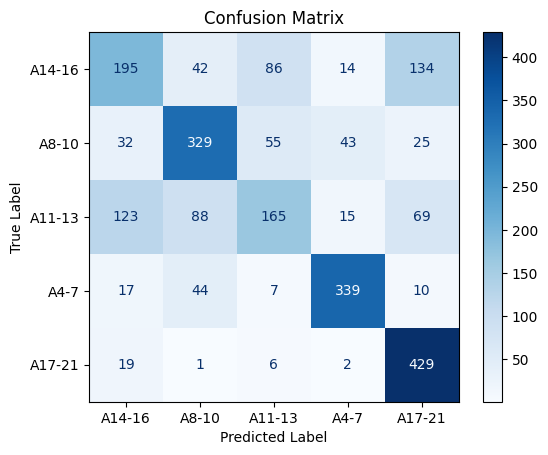

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate the model and get predictions
y_pred = model.predict(X_test)

# Convert the predictions from one-hot encoded to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
labels = ['A14-16', 'A8-10', 'A11-13', 'A4-7', 'A17-21']  # Adjust according to your labels

plt.figure(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

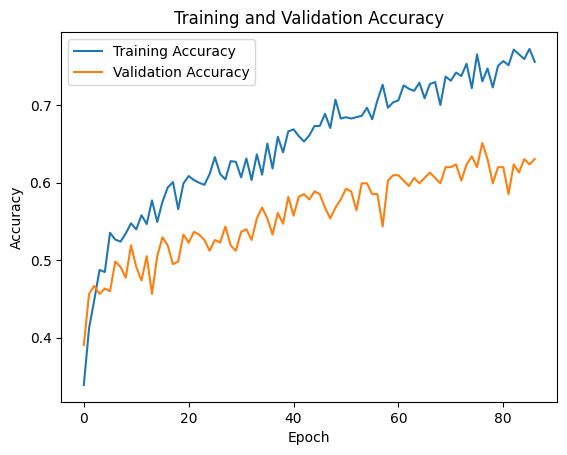

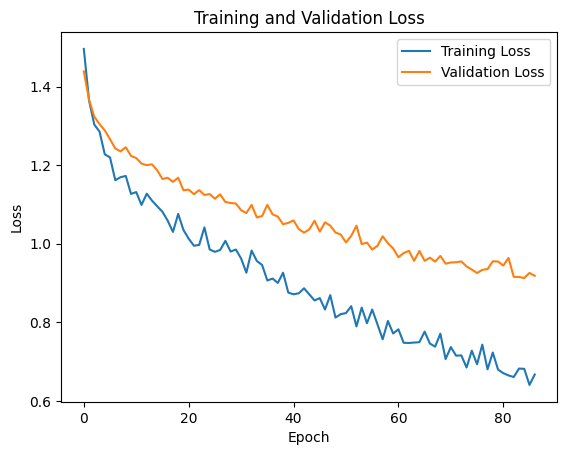

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()